In [102]:
import torch
import torchvision
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import numpy as np


In [103]:
train = datasets.MNIST('',train = True, download = True, transform = transforms.Compose([transforms.ToTensor()]))
trainset = torch.utils.data.DataLoader(train,batch_size = 32,shuffle = True)
test = datasets.MNIST('',train = False, download = True, transform = transforms.Compose([transforms.ToTensor()]))
testset = torch.utils.data.DataLoader(test,batch_size = 32,shuffle = True)
print(train.data.size())

torch.Size([60000, 28, 28])


In [104]:
import torch.nn as nn
import torch.nn.functional as F

In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [106]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    #encoding layers
    self.conv1 = nn.Conv2d(1,32,3,padding=1,stride=2) # 28x28 --> 14x14
    self.conv2 = nn.Conv2d(32,64,3,padding=1,stride=2) # 14x14 --> 7x7
    self.conv3 = nn.Conv2d(64,128,5) # 7x7 --> 3x3


    #decoding layers
    self.tconv1 = nn.ConvTranspose2d(128,64,5) # 3x3 --> 7x7
    self.tconv2 = nn.ConvTranspose2d(64,32,3,stride=2,padding=1,output_padding=1) # 7x7 --> 14x14
    self.tconv3 = nn.ConvTranspose2d(32,1,3,stride=2,padding=1,output_padding=1) # 14x14 --> 28x28


  #forward prop function
  def forward(self,x):
    x = F.relu(self.conv1(x))
    # print(x.size())
    x = F.relu(self.conv2(x))
    # print(x.size())
    x = F.relu(self.conv3(x))
    # print(x.size())

    x = F.relu(self.tconv1(x))
    # print(x.size())
    x = F.relu(self.tconv2(x))
    # print(x.size())
    x = F.sigmoid(self.tconv3(x)) #final layer is applied sigmoid activation
    # print(x.size())

    return x

model = Model()
print(model)


Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (tconv1): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (tconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (tconv3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


In [107]:
model.to(device) #shifting model to cuda

Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (tconv1): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (tconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (tconv3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

In [122]:
import torch.optim as optim
loss_function = nn.MSELoss() #mean-squared error loss_function
optimizer = optim.Adam(model.parameters(),lr=0.001, weight_decay = 1e-5)

In [123]:
#function to add noise to input images
def add_noise(inputs,noise_factor=0.3):
  noisy = inputs + (torch.randn_like(inputs) * noise_factor)
  noisy = torch.clip(noisy,0.,1.)
  return noisy

In [124]:
losses = [] #list containing average loss of each epoch
non_avg_loss = []
all_losses = []
running_loss = 0
l = len(trainset)
append_counter = 0
#training loop
for epoch in range(10):
  for t in trainset:
    images,_ = t
    noisy_images = add_noise(images)
    images = images.to(device)
    noisy_images = noisy_images.to(device) #shifting noisy images to cuda


    output = model(noisy_images)

    loss = loss_function(output,images) #loss is calculated between model output and og dataset images
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss+=loss.item()
    all_losses.append(loss.item())
    append_counter +=1
    if(append_counter == 180):
      non_avg_loss.append(loss.item())
      append_counter = 0
  losses.append(running_loss/l)
  running_loss = 0
  print(loss) #prints loss of the last batch of the epoch

tensor(0.0063, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward0>)


In [125]:
#moving images to cpu for plotting
noisy_images_cpu = noisy_images.cpu()
output_cpu = output.cpu()

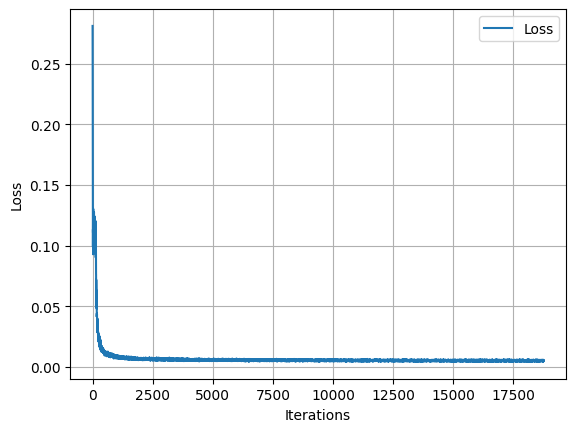

In [128]:
fig, ax = plt.subplots(1,1)
ax.plot(all_losses, label='Loss')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

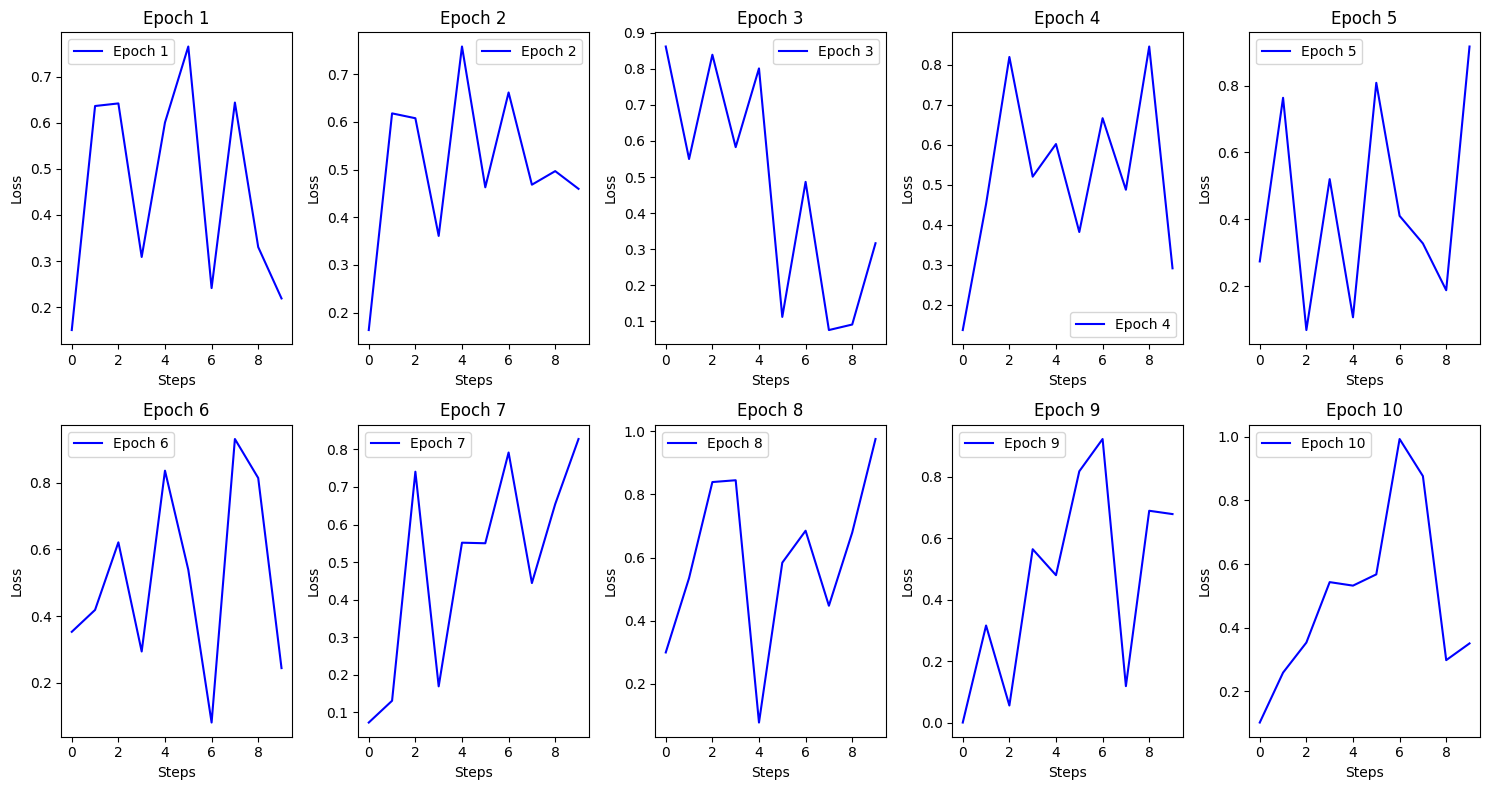

In [129]:
non_avg_loss = np.random.rand(104)

# Number of epochs
epochs = 10
values_per_epoch = len(non_avg_loss) // epochs

# Create subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 8))  # Adjust figsize for better spacing

# Flatten axes for easy iteration
axes = axes.flatten()

# Loop through each epoch and plot its losses
for i in range(epochs):
    start_idx = i * values_per_epoch
    end_idx = start_idx + values_per_epoch
    axes[i].plot(non_avg_loss[start_idx:end_idx], label=f'Epoch {i+1}', color='blue')

    axes[i].set_xlabel('Steps')
    axes[i].set_ylabel('Loss')
    axes[i].set_title(f'Epoch {i+1}')
    axes[i].legend()

# Adjust layout
plt.tight_layout()

plt.show()


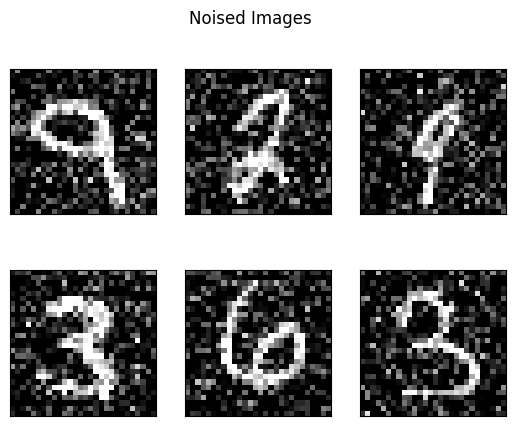

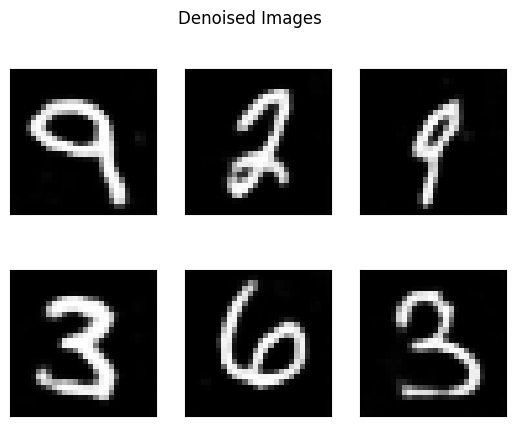

In [130]:
noisy_images_cpu = noisy_images_cpu.detach().numpy()
noisy_images_cpu = noisy_images_cpu.reshape(-1,28,28)
output_cpu = output_cpu.detach().numpy()
output_cpu = output_cpu.reshape(-1,28,28)
plt.suptitle('Noised Images')
for j in range(6):
  plt.subplot(2,3,j+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(noisy_images_cpu[j],cmap='gray')
plt.show()
plt.suptitle('Denoised Images')
for j in range(6):
  plt.subplot(2,3,j+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(output_cpu[j],cmap='gray')
plt.show()

In [131]:
#finding results on testset
with torch.no_grad():
  for img,_ in testset:
    noisy_img = add_noise(img)
    noisy_img = noisy_img.to(device)
    reconstructed = model(noisy_img)

In [132]:
img = img.cpu()
noisy_img = noisy_img.cpu()
reconstructed = reconstructed.cpu()

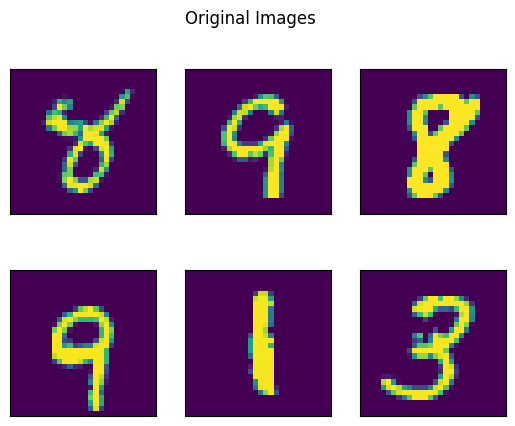

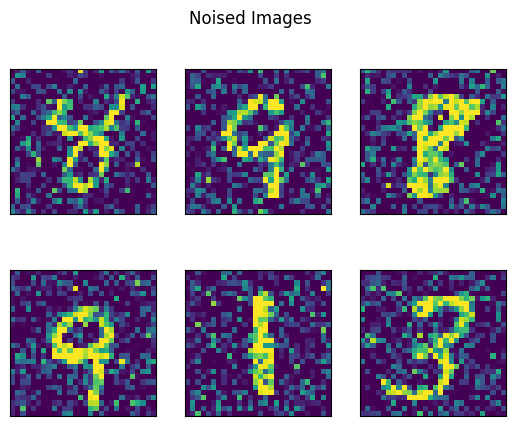

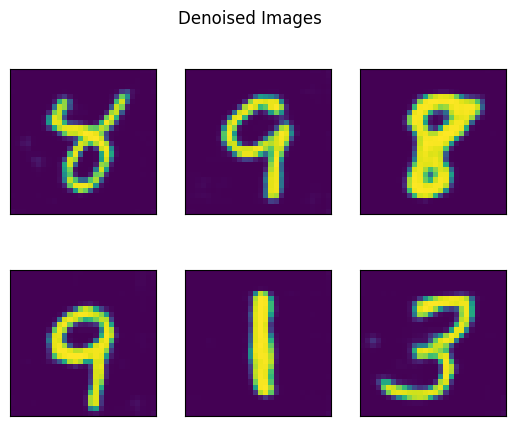

In [133]:
img = img.detach().numpy()
img = img.reshape(-1,28,28)
noisy_img = noisy_img.detach().numpy()
noisy_img = noisy_img.reshape(-1,28,28)
reconstructed = reconstructed.detach().numpy()
reconstructed = reconstructed.reshape(-1,28,28)
plt.suptitle('Original Images')
for p in range(6):
  plt.subplot(2,3,p+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img[p])
plt.show()
plt.suptitle('Noised Images')
for p in range(6):
  plt.subplot(2,3,p+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(noisy_img[p])
plt.show()
plt.suptitle('Denoised Images')
for p in range(6):
  plt.subplot(2,3,p+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(reconstructed[p])
plt.show()

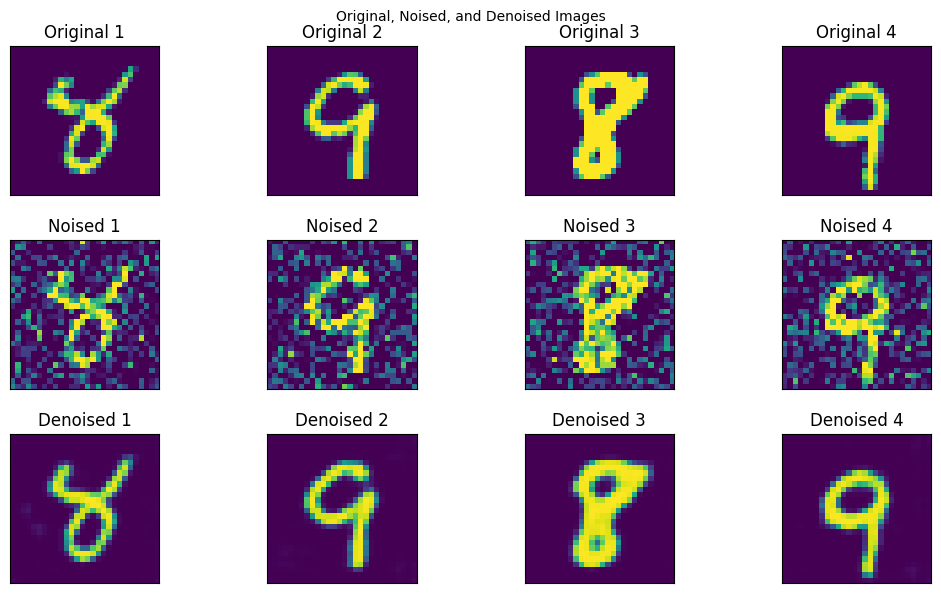

In [135]:
## Better plotting using ChatGPT (Edited in 2024)
# Create a figure with 3 rows (one for each image type) and 6 columns (for the 6 images)
fig, axes = plt.subplots(3, 4, figsize=(10, 6))  # Increased figsize for more space

# Titles for each row
plt.suptitle('Original, Noised, and Denoised Images', fontsize=10)

# Plot the original images in the first row
for p in range(4):
    ax = axes[0, p]  # First row, each column for the original images
    ax.imshow(img[p])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Original {p+1}', fontsize=12)

# Plot the noisy images in the second row
for p in range(4):
    ax = axes[1, p]  # Second row, each column for the noised images
    ax.imshow(noisy_img[p])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Noised {p+1}', fontsize=12)

# Plot the denoised images in the third row
for p in range(4):
    ax = axes[2, p]  # Third row, each column for the denoised images
    ax.imshow(reconstructed[p])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Denoised {p+1}', fontsize=12)

# Adjust layout and add spacing between plots
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.3, wspace=0.3)  # Increase space between subplots

plt.show()
